In [ ]:
import sys
import os

# Add the project directory of "tests" to sys.path
sys.path.append(os.path.abspath("/Users/workspace/Software/Layered_Tank_Simulation/CherenkovSim/"))

In [2]:
from cherenkov_sim.particle import Particle
from cherenkov_sim.muon import Muon
from cherenkov_sim.gamma import Gamma
from cherenkov_sim.material import Material
from cherenkov_sim.tracker import ParticleTracker, GammaTracker
from cherenkov_sim.constants import ALPHA, R_TANK, H_TANK, TOP_TANK, ELECTRON_MASS

import numpy as np
from astropy import units as u
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
ice = Material(
    name = 'Ice',
    Z_A = 0.55509 * u.mol / u.g,
    rho = 0.9180 * u.g / u.cm**3,
    I = 79.7 * u.eV, 
    n = 1.309,
    X0 = 39.31 * u.cm, 
    delta_file = '/Users/workspace/Software/PHYS-F-420/lesson2/delta_elec.txt',
    att_file = '/Users/workspace/Software/Layered_Tank_Simulation/CherenkovSim/cherenkov_sim/water_gamma_cross_section.txt'
)

water = Material(
    name = 'water',
    Z_A = 0.55509 * u.mol / u.g,
    rho = 1 * u.g / u.cm**3,
    I = 79.7 * u.eV,
    n = 1.333,
    X0 = 36.08 * u.cm, 
    delta_file = '/Users/workspace/Software/PHYS-F-420/lesson2/delta_elec.txt',
    att_file = '/Users/workspace/Software/Layered_Tank_Simulation/CherenkovSim/cherenkov_sim/water_gamma_cross_section.txt'
)

In [4]:
# Define primary energy 
e = 0.01 * u.GeV

In [5]:
# Extract starting position randomly from a circle corresponding to the top of the tank
N_event = int(1e4) # Choose number of particles 

# Gen. surface radius 
R_gen = 180 * u.cm 
 
def rnd_tank_start(R_gen, N_event): 
    r = R_gen * np.sqrt(np.random.uniform(0,1,size=N_event))
    alpha = np.random.uniform(0,2*np.pi, size=N_event) 
    z_value = 140 
    x0 = r * np.cos(alpha)   
    y0 = r * np.sin(alpha)  
    z0 = np.full(N_event,z_value) * u.cm
    return x0, y0, z0   


def rnd_direction(N_event):
    phi = np.random.uniform(0,2*np.pi, size=N_event)

    theta_0 = 0 * u.deg 
    theta_1 = 30 * u.deg 
    cos_theta_squared = np.random.uniform(np.cos(theta_1.to(u.rad))**2,np.cos(theta_0.to(u.rad))**2, size=N_event)
    cos_theta = np.sqrt(cos_theta_squared)
    theta = np.arccos(cos_theta) 
    return theta * u.rad, phi * u.rad

In [6]:
# Track muons inside the tank, considering energy loss and Cherenkov produciton 

muon_theta, muon_phi = rnd_direction(N_event)
x0,y0,z0 = rnd_tank_start(R_gen, N_event)  

initial_position = np.array([x0[0].value,y0[0].value,z0[0].value]) * u.cm
theta = muon_theta[0]

In [7]:
# Create list to store photon position 

all_photons = []
all_photons_z = []
all_photons_r = []

In [8]:
counter = 0

for i_evt in range(0, N_event):

    counter += 1

    # Define particle 
    gamma = Gamma(energy = e)

    # Create the Tracker

    initial_position = np.array([x0[i_evt].value,y0[i_evt].value,z0[i_evt].value]) * u.cm

    gamma_tracker = GammaTracker(gamma, water, step_size= - 1.0 * u.cm,
                      position=initial_position, 
                      zenith=muon_theta[i_evt], 
                      azimuth=muon_phi[i_evt],
                      is_verbose = False)
    
    if(counter % 500 == 0):print('Simulating gamma track #',i_evt)

    out = gamma_tracker.propagate()

    for tracker in gamma_tracker.electron_trackers_queue:
        tracker.propagate(lambda1 = 300 * u.nm, lambda2 = 600 * u.nm)
        all_photons_z.extend(tracker.cherenkov_photons_z)
        all_photons_r.extend(tracker.cherenkov_photons_r)



/opt/anaconda3/envs/tank_env/lib/python3.12/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Simulating gamma track # 499
Simulating gamma track # 999
Simulating gamma track # 1499
Simulating gamma track # 1999
Simulating gamma track # 2499
Simulating gamma track # 2999
Simulating gamma track # 3499
Simulating gamma track # 3999
Simulating gamma track # 4499
Simulating gamma track # 4999
Simulating gamma track # 5499
Simulating gamma track # 5999
Simulating gamma track # 6499
Simulating gamma track # 6999
Simulating gamma track # 7499
Simulating gamma track # 7999
Simulating gamma track # 8499
Simulating gamma track # 8999
Simulating gamma track # 9499
Simulating gamma track # 9999


In [9]:
len(all_photons_z)

9973773

In [10]:
# Define range and bins of photon density histogram 

bin_width = 10
r_bins = np.arange(0,R_TANK.value+bin_width,bin_width)
z_bins = np.arange(0,H_TANK.value+bin_width,bin_width)

# Compute volume corresponding to each bin 
r_min, r_max = r_bins[:-1], r_bins[1:]
z_min, z_max = z_bins[:-1], z_bins[1:]

vol = np.zeros((len(r_min),len(z_min))) 
r_centers = (r_min+r_max) / 2.
z_centers = (z_min + z_max) / 2.

for i in range(len(r_min)): 
    for j in range(len(z_min)): 
        vol[i][j] = np.pi * (r_max[i]**2-r_min[i]**2)*(z_max[j]-z_min[j])
        
r_centers, z_centers = np.meshgrid(r_centers,z_centers)  

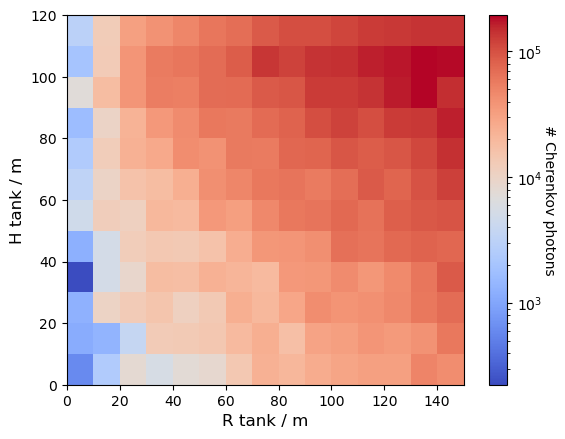

In [11]:
hist2d = plt.hist2d(all_photons_r, all_photons_z, bins=[r_bins,z_bins], norm=mpl.colors.LogNorm(), cmap = plt.cm.coolwarm )
#hist2d = plt.hist2d(r_photon, z_photon, bins=[r_bins,z_bins], norm=mpl.colors.LogNorm(vmin=np.min(hist2d[0])), cmap = plt.cm.coolwarm)
#hist2d = plt.hist2d(r_photon, z_photon, bins=[r_bins,z_bins], cmap = plt.cm.coolwarm)

plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)
cbar = plt.colorbar()
cbar.set_label('# Cherenkov photons', rotation=270, labelpad=10)

(12, 15)
(12, 15)


Text(0, 0.5, 'H tank / m')

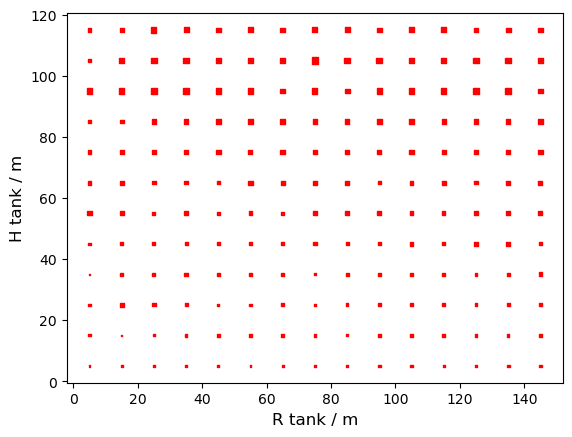

In [12]:
plt.figure(dpi=100)
bin_count = hist2d[0]
ph_density = bin_count / vol 

print(r_centers.shape)
print(z_centers.shape)

#plt.scatter(r_centers, z_centers, c = ph_density.T, marker='s')
#plt.colorbar()

plt.scatter(r_centers, z_centers, s=ph_density.T*7, marker='s', c='red')
plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)

(array([  77905.,  305389.,  483661.,  660111.,  880256., 1088052.,
        1324675., 1493562., 1736402., 1923760.]),
 array([  0.2735243 ,  15.29858636,  30.32364841,  45.34871047,
         60.37377253,  75.39883459,  90.42389665, 105.4489587 ,
        120.47402076, 135.49908282, 150.52414488]),
 <BarContainer object of 10 artists>)

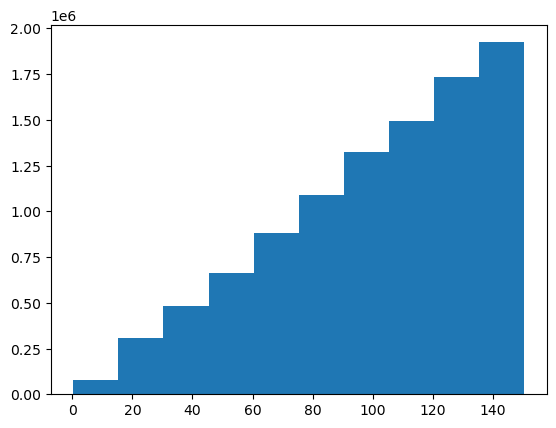

In [13]:
plt.hist(all_photons_r)

In [14]:
mask = np.logical_and(all_photons_z > TOP_TANK.value, all_photons_z < H_TANK.value )

In [15]:
mask

array([ True,  True,  True, ...,  True,  True,  True])

In [16]:
len(np.asarray(all_photons_z)[mask])

5359533